In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

## 策略模型定义

In [ ]:
import torch
import torch.nn as nn

class LSTMPolicyNet(nn.Module):
    def __init__(self, state_dim=10, lstm_hidden=128, mlp_hidden=128, num_layers=1, dropout=0.1):
        super().__init__()
        self.state_dim = state_dim
        self.lstm_hidden = lstm_hidden
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=state_dim,
            hidden_size=lstm_hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.mlp = nn.Sequential(
            nn.Linear(lstm_hidden + state_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, 2)  # 输出2个动作的logits
        )

    def forward(self, state_seq, hidden=None):
        """
        state_seq: [B, T, state_dim]  # batch, seq_len, state_dim
        hidden: (h0, c0) tuple for LSTM initial state (optional)
        Returns:
            action_logits: [B, T, 2]  # 每个时刻的动作分数
        """
        lstm_out, hidden = self.lstm(state_seq, hidden)  # lstm_out: [B, T, lstm_hidden]
        logits = self.mlp(torch.cat((lstm_out, state_seq), dim=-1))  # [B, T, lstm_hidden + state_dim] -> [B, T, 2]
        return logits, hidden

    def act(self, state_seq, hidden=None, deterministic=False):
        """
        用于采样动作
        state_seq: [B, T, state_dim]
        Returns:
            actions: [B, T]
        """
        logits, hidden = self.forward(state_seq, hidden)
        probs = torch.softmax(logits, dim=-1)
        if deterministic:
            actions = torch.argmax(probs, dim=-1)
        else:
            dist = torch.distributions.Categorical(probs)
            actions = dist.sample()
        return actions, probs, hidden

    def reset_hidden(self, batch_size):
        """
        重置LSTM的隐藏状态
        batch_size: int
        Returns:
            hidden: (h0, c0) tuple for LSTM initial state
        """
        h0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        c0 = torch.zeros(self.num_layers, batch_size, self.lstm_hidden).to(next(self.parameters()).device)
        return (h0, c0)

## 加载ReplayDataset

In [3]:
import datasets

ReplayDataset = datasets.load_from_disk("../data/scores_rb/shareGPT-llama3-d7-topk10-t1")

In [4]:
# ReplayDataset.set_format("torch")
# type(ReplayDataset["train"][0]["action_7"]["stop"])

In [5]:
ReplayDataset["train"][0]

{'eagle_1_forward': [-1.028,
  -1.31,
  -1.489,
  -2.748,
  -3.365,
  -3.592,
  -4.94,
  -5.656,
  -5.742,
  -6.645],
 'eagle_2_forward': [-1.049,
  -1.315,
  -1.489,
  -3.074,
  -3.375,
  -3.592,
  -4.56,
  -4.926,
  -4.996,
  -5.34],
 'eagle_3_forward': [-1.052,
  -1.491,
  -2.14,
  -2.953,
  -2.953,
  -3.14,
  -3.879,
  -4.074,
  -4.273,
  -4.555],
 'eagle_4_forward': [-1.326,
  -1.562,
  -2.955,
  -3.25,
  -3.305,
  -3.719,
  -3.84,
  -3.922,
  -4.133,
  -4.258],
 'eagle_5_forward': [-1.343,
  -1.564,
  -3.41,
  -3.58,
  -3.846,
  -3.986,
  -4.27,
  -4.465,
  -5.023,
  -5.06],
 'eagle_6_forward': [-1.343,
  -1.565,
  -3.426,
  -3.852,
  -4.664,
  -4.68,
  -4.734,
  -4.85,
  -5.36,
  -5.51],
 'eagle_7_forward': [-1.72,
  -1.849,
  -2.86,
  -3.098,
  -3.719,
  -4.453,
  -4.453,
  -4.516,
  -4.684,
  -5.055],
 'eagle_8_forward': [-2.912,
  -2.938,
  -3.562,
  -3.7,
  -3.781,
  -3.9,
  -3.93,
  -3.945,
  -4.055,
  -4.08],
 'action_0': {'stop': [0.00017976760864257812, 0.999776840209960

## 奖励函数

In [6]:
import numpy as np
# 1. 奖励函数（期望reward）
def reward_fn(action_idx, stop_probs, lam1=1.0, lam2=0.9):
    n = action_idx
    probs = np.array(stop_probs[1:], dtype=np.float32)
    probs[0] += stop_probs[0]  # 合并长度为0和1的概率
    l_arr = np.arange(len(probs))  # [0, 1, ..., len(probs)-1]
    reward_arr = lam1 * l_arr - lam2 * np.abs(n - l_arr)
    expected_reward = np.sum(probs * reward_arr)
    return expected_reward

In [ ]:
def avg_acc_len_fn(stop_probs):
    return np.sum(np.arange(len(stop_probs)) * np.array(stop_probs, dtype=np.float32))

def avg_acc_len_fn_tensor(stop_probs:torch.Tensor):
    """stop_probs: [B, T]"""
    return torch.sum(torch.arange(stop_probs.size(-1), device=stop_probs.device) * stop_probs, dim=-1)

def padding_stops(stops, max_len=9):
    """
    对stops进行padding，使其长度为max_len
    0~8共9个位置
    """
    padded_stops = stops + [0.0] * (max_len - len(stops))
    return padded_stops[:max_len]  # 确保长度不超过max_len

## 数据集定义

In [ ]:
from torch.utils.data import Dataset

class SharedStatesDataset(Dataset):
    def __init__(self, dataset, max_len=7):
        self.samples = []
        for sample in dataset:
            # 仅用eagle_1_forward ~ eagle_7_forward
            state_seq = [sample[f'eagle_{i}_forward'] for i in range(1, max_len+1)]  # [7, state_dim]
            stops = [padding_stops(sample[f'action_{i}']['stop']) for i in range(max_len+1)] # [8, 9]
            # rewards = [reward_fn(i, stops[i]) for i in range(max_len+1)]
            avg_acc_lens_op = avg_acc_len_fn(stops[-1])  # 最优平均接受长度
            self.samples.append({
                "states": state_seq,     # [7, state_dim]
                # "all_rewards": rewards,  # [8]
                "stop_probs": stops,
                "avg_acc_lens_op": avg_acc_lens_op
            })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def collate_fn(batch):
    states = torch.tensor([x["states"] for x in batch], dtype=torch.float32) # [B, 7, state_dim]
    # all_rewards = torch.tensor([x["all_rewards"] for x in batch], dtype=torch.float32) # [B, 8]
    stop_probs = torch.tensor([x["stop_probs"] for x in batch], dtype=torch.float32)  # [B, 8, 9]
    avg_acc_lens_op = torch.tensor([x["avg_acc_lens_op"] for x in batch], dtype=torch.float32)  # [B]
    return states, stop_probs, avg_acc_lens_op  
    # return states, all_rewards


## 参数

In [8]:
max_len = 7
num_paths = max_len + 1  # 8

## 构造奖励矩阵

In [9]:
ACTION_SEQ_MATRIX = torch.stack([
        torch.tensor([1] * i + [0] * (num_paths - i - 1), dtype=torch.long)
        for i in range(num_paths)
    ])  # [8, 7]
MASK_MATRIX = torch.tril(torch.ones((num_paths, num_paths), dtype=torch.float32))[:, :-1]  # [8, 7]

In [10]:
ACTION_SEQ_MATRIX

tensor([[0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1]])

In [11]:
MASK_MATRIX

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.]])

In [ ]:
from torch.utils.data import DataLoader
train_set = ReplayDataset["train"]
test_set = ReplayDataset["test"]
train_dataset = SharedStatesDataset(train_set, max_len=max_len)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataset = SharedStatesDataset(test_set, max_len=max_len)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [ ]:
def make_reward_matrix(maxlen=7):
    rewards = torch.ones(maxlen+2, maxlen+1, maxlen+1, dtype=torch.long)
    for al in range(9):
        rewards[al, :, max(al-1, 0):] = -1
    rewards = rewards[:,:,:maxlen]

    action = torch.tensor(
        [
            [1] * i + [0] * (maxlen - i) for i in range(maxlen + 1)
        ]
    )

    mask = torch.tril(torch.ones(maxlen+1,maxlen+1,dtype=torch.long))[:,:maxlen]

    R = rewards * (2 * action - 1) * mask # [9,8,7] acclen,action_idx,reward
    return R

## 统计接受长度分布、平均接受长度

In [ ]:
def mask_after_first_zero(tensor):
    """
    参数:
        tensor: 输入张量，形状为[bsz, 8],仅包含整数值0或1
    
    返回:
        形状为[bsz, 8]的张量,第一个0之后的所有位置被置0
    """
    # 1. 找出所有0的位置
    zeros = tensor.eq(0)
    
    # 2. 创建累积mask（为第一个0之后的位置标记为False）
    # 使用cumprod将第一个0之前的True保留，之后的变为False
    mask = torch.cat(
        [torch.ones(zeros.size(0), 1, dtype=torch.bool, device=tensor.device),
         ~zeros[:, :-1]], 
        dim=1
    ).cumprod(dim=1).bool()
    
    return tensor * mask

def find_first_zero_pos(tensor):
    """
    参数:
        tensor: 输入张量，形状为[bsz, 8]，仅包含整数值0或1
    
    返回:
        形状为[bsz, 1]的张量，表示每行第一个0的位置（若没有则为8）
    """
    # 步骤1: 创建布尔掩码标记0的位置
    mask = tensor.eq(0)  # 等同于 (tensor == 0)
    mask = mask.to(torch.long)
    
    # 步骤2: 在最后一维末尾添加全True的列
    extended_mask = torch.cat(
        [mask, torch.ones(mask.size(0), 1, dtype=torch.long, device=tensor.device)],
        dim=1
    )
    
    # 步骤3: 沿最后一维查找第一个True的位置索引
    first_zero_pos = extended_mask.argmax(dim=1, keepdim=True)
    return first_zero_pos

from collections import defaultdict
def cal_avg_len(model, data_loader):
    model.eval()
    len_dict = defaultdict(list)

    with torch.no_grad():
        for states, stop_probs, avg_acc_lens_op in data_loader:
            # states: [B, 7, state_dim], stop_probs: [B, 8, 8], avg_acc_lens_op: [B]
            batch_size = states.size(0)
            hidden = model.reset_hidden(batch_size)
            actions, _, _ = model.act(states, hidden)  # [B, T]
            # actions中第一个0出现的位置为动作序列长度
            action_length = find_first_zero_pos(actions)  # [B, 1]
            expanded_index = action_length.unsqueeze(-1).expand(-1, -1, stop_probs.size(-1))  # [B, 1, max_len + 1]
            action_stop_probs = stop_probs.gather(dim=1, index=expanded_index).squeeze(1) # [B, max_len + 1]
            # 计算平均接受长度
            avg_acc_lens = avg_acc_len_fn_tensor(action_stop_probs) # [B]
            len_dict["avg_acc_lens"].extend(avg_acc_lens.cpu().numpy())
            # 计算与最优平均接受长度差值
            optimal_avg_acc_lens = avg_acc_lens - avg_acc_lens_op
            len_dict["optimal_avg_acc_lens_diff"].extend(optimal_avg_acc_lens.cpu().numpy())
            
    return len_dict
    

## 测试代码

In [53]:
def evaluate_loss(model, data_loader, action_seq_matrix, mask_matrix, device="cpu"):
    model.eval()
    total_loss = 0
    total_batches = 0

    with torch.no_grad():
        for states, all_rewards in data_loader:
            states = states.to(device)
            all_rewards = all_rewards.to(device)
            reward_mean = all_rewards.mean(dim=0, keepdim=True)  # [1, 8]
            reward_std = all_rewards.std(dim=0, keepdim=True) + 1e-8  # 防止除0
            all_rewards = (all_rewards - reward_mean) / reward_std  # 中心化
            logits, _ = model(states)  # [B, 7, 2]

            B = logits.shape[0]
            log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
            log_probs_exp = log_probs.unsqueeze(1).expand(-1, num_paths, -1, -1)  # [B, 8, 7, 2]

            action_seq = action_seq_matrix.to(device).unsqueeze(0).expand(B, -1, -1)  # [B, 8, 7]
            mask = mask_matrix.to(device).unsqueeze(0).expand(B, -1, -1)  # [B, 8, 7]

            action_log_probs = torch.gather(
                log_probs_exp, dim=-1, index=action_seq.unsqueeze(-1)
            ).squeeze(-1)  # [B, 8, 7]

            log_prob_sum = (action_log_probs * mask).sum(dim=-1)  # [B, 8]
            loss_paths = -(log_prob_sum * all_rewards).mean(dim=0)  # [8]
            loss = loss_paths.mean()
            total_loss += loss.item()
            total_batches += 1
    model.train()
    return total_loss / total_batches if total_batches > 0 else float('inf')

## 训练代码

Epoch 1, Train Loss: -5.1226, Test Loss: -14.7287
Epoch 2, Train Loss: -28.9622, Test Loss: -45.8803
Epoch 3, Train Loss: -68.1492, Test Loss: -93.1043
Epoch 4, Train Loss: -123.4787, Test Loss: -157.1438
Epoch 5, Train Loss: -196.9854, Test Loss: -240.1278
Epoch 6, Train Loss: -287.2303, Test Loss: -339.0928
Epoch 7, Train Loss: -394.5657, Test Loss: -456.0052
Epoch 8, Train Loss: -522.3500, Test Loss: -595.8123
Epoch 9, Train Loss: -672.2739, Test Loss: -756.1336
Epoch 10, Train Loss: -841.0980, Test Loss: -935.4385


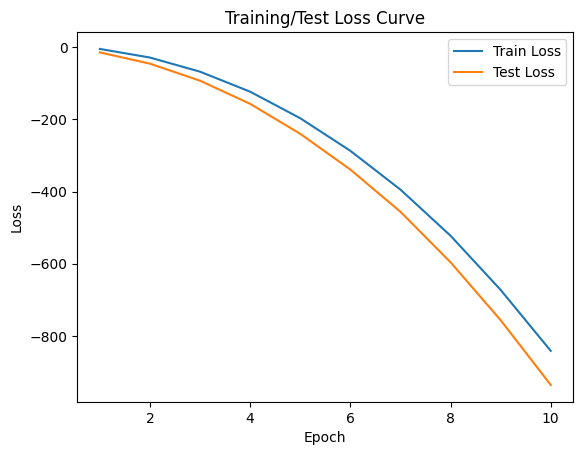

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


state_dim = np.array(train_dataset[0]["states"]).shape[1]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMPolicyNet(state_dim=state_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  

action_seq_matrix = ACTION_SEQ_MATRIX
mask_matrix = MASK_MATRIX

num_epochs = 10
train_losses = []
test_losses = []
best_test_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_batches = 0
    for states, stop_probs, _ in train_loader:
        states = states.to(device)

        logits, _ = model(states)  # [B, 7, 2]
        log_probs = nn.functional.log_softmax(logits, dim=-1)  # [B, 7, 2]
        probs = torch.softmax(logits, dim=-1)  # [B, 7, 2]
        dist = torch.distributions.Categorical(probs=probs)  # 创建Categorical分布
        sampled_actions = dist.sample()  # 采样动作 [B, 7]

        
        # loss = 
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1

    avg_train_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_test_loss = evaluate_loss(model, test_loader, action_seq_matrix, mask_matrix, device)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    # if avg_test_loss < best_test_loss:
    #         best_test_loss = avg_test_loss
    #         torch.save(model.state_dict(), "lstm_policy.pt")
    #         print(f"Best test loss updated: {best_test_loss:.4f}, model checkpoint saved.")

# 可视化loss
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training/Test Loss Curve")
plt.savefig("loss_curve.png")
plt.show()

torch.save(model.state_dict(), "lstm_policy.pt")